# 1. Pre-processing

#### 1.1. Text Pre-processing

The dataset is already lowercased and lacks punctuation. We will tokenize the text and remove stopwords, as well as apply lemmatization to the tokens.

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

data = pd.read_json('./data/data.jsonl', lines=True)
def pre_process_data(dataset):
    #tokenize
    dataset['text'] = dataset['text'].apply(nltk.word_tokenize)

    #remove stop words
    stop_words = set(stopwords.words('english'))
    dataset['text'] = dataset['text'].apply(lambda x: [word for word in x if word not in stop_words])

    #lemmatize
    lemmatizer = WordNetLemmatizer()
    dataset['text'] = dataset['text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

    return dataset

data = pre_process_data(data)
data.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fabio\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fabio\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fabio\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,text,label
0,"[feel, awful, job, get, position, succeed, hap...",0
1,"[im, alone, feel, awful]",0
2,"[ive, probably, mentioned, really, feel, proud...",1
3,"[feeling, little, low, day, back]",0
4,"[beleive, much, sensitive, people, feeling, te...",2


In [34]:
test_data = pd.read_json('./data/test.jsonl', lines=True)
train_data = pd.read_json('./data/train.jsonl', lines=True)
validation_data = pd.read_json('./data/validation.jsonl', lines=True)

test_data = pre_process_data(test_data)
train_data = pre_process_data(train_data)
validation_data = pre_process_data(validation_data)

# 2. Vectorization
(secção possívelmente temporária, mas queria experimentar as cenas de tf_idf depois do pré-processamento) -- matos
não acho que convenha ser temporaria, dado que efetivamente melhora os resultados ihihihi, e é uma prática comum e recomendada pelo que estivemos a ver -- ines


In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidfVectorizer(data):
    vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_features=40000)
    # good idea to use two-grams??
    # print(X.shape)

    X = vectorizer.fit_transform(data['text'].apply(lambda x: ' '.join(x)))

    x_train = vectorizer.transform(train_data['text'].apply(lambda x: ' '.join(x)))
    x_val = vectorizer.transform(validation_data['text'].apply(lambda x: ' '.join(x)))
    x_test = vectorizer.transform(test_data['text'].apply(lambda x: ' '.join(x)))

    y_train = train_data['label']
    y_val = validation_data['label']
    y_test = test_data['label']
    
    # print(vectorizer.get_feature_names_out())

    return x_train, x_val, x_test, y_train, y_val, y_test



In [36]:
# print(train_data['text'][0])

In [37]:
from sklearn.feature_extraction.text import CountVectorizer

def countVectorizer(data):
    # Initialize CountVectorizer
    vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,2), max_features=40000)

    X = vectorizer.fit_transform(data['text'].apply(lambda x: ' '.join(x)))

    x_train = vectorizer.transform(train_data['text'].apply(lambda x: ' '.join(x)))
    x_val = vectorizer.transform(validation_data['text'].apply(lambda x: ' '.join(x)))
    x_test = vectorizer.transform(test_data['text'].apply(lambda x: ' '.join(x)))

    y_train = train_data['label']
    y_val = validation_data['label']
    y_test = test_data['label']

    return x_train, x_val, x_test, y_train, y_val, y_test



In [1]:
from gensim.models import Word2Vec
import numpy as np
import gensim.downloader as api


def text_to_vector(embeddings, text, sequence_len):
    
    # split text into tokens
    tokens = text.split()
    
    # convert tokens to embedding vectors, up to sequence_len tokens
    vec = []
    n = 0
    i = 0
    while i < len(tokens) and n < sequence_len:   # while there are tokens and did not reach desired sequence length
        try:
            vec.extend(embeddings.get_vector(tokens[i]))
            n += 1
        except KeyError:
            True   # simply ignore out-of-vocabulary tokens
        finally:
            i += 1
    
    # add blanks up to sequence_len, if needed
    for j in range(sequence_len - n):
        vec.extend(np.zeros(embeddings.vector_size,))
    
    return vec

def documents_to_vectors(embeddings, documents, sequence_len):
    vectors = []
    for doc in documents:
        vectors.append(text_to_vector(embeddings, doc, sequence_len))
    return np.array(vectors)

def wordEmbeddingsVectorizer(data):
    
    # use twitter word embeddings
    model_glove_twitter = api.load("glove-twitter-25")
    
    # Initialize Word2Vec
    
    train = train_data['text'].apply(lambda x: ' '.join(x))
    val = validation_data['text'].apply(lambda x: ' '.join(x))
    test = test_data['text'].apply(lambda x: ' '.join(x))
    
    x_train = documents_to_vectors(model_glove_twitter, train, 40)
    x_val = documents_to_vectors(model_glove_twitter, val, 40)
    x_test = documents_to_vectors(model_glove_twitter, test, 40)
    
    print(x_train.shape, x_val.shape, x_test.shape)
    print(x_train[0])
    
    y_train = train_data['label']
    y_val = validation_data['label']
    y_test = test_data['label']

    return x_train, x_val, x_test, y_train, y_val, y_test

w = wordEmbeddingsVectorizer(data)


NameError: name 'data' is not defined

In [39]:
# Choose vectorizer (featurizer)
#x_train, x_val, x_test, y_train, y_val, y_test = tfidfVectorizer(data)
# x_train, x_val, x_test, y_train, y_val, y_test = countVectorizer(data)
x_train, x_val, x_test, y_train, y_val, y_test = wordEmbeddingsVectorizer(data)

## Apply SMOTE
smote = SMOTE(random_state=42, sampling_strategy='auto', k_neighbors=10)
x_train, y_train = smote.fit_resample(x_train, y_train)

print(y_train.value_counts())

(16000, 1000) (2000, 1000) (2000, 1000)
[ 4.19470012e-01  1.29410005e+00  6.70970023e-01 -6.70780003e-01
 -9.17410016e-01 -8.08440030e-01  1.10060000e+00 -7.24110007e-01
 -6.08519971e-01 -1.35250002e-01 -4.54290003e-01  7.31779993e-01
 -4.35699987e+00 -5.53900003e-01  4.69230004e-02  6.74009979e-01
  9.05510008e-01 -7.65640020e-01 -2.02439994e-01 -8.44799995e-01
  9.66989994e-01  7.94879973e-01  8.38840008e-01  8.49330008e-01
 -4.69760001e-01 -3.30000013e-01  6.72309995e-02  1.53259993e-01
 -1.71059996e-01 -2.59229988e-01  9.42009985e-01  2.27589989e+00
 -1.67559996e-01 -1.03540003e+00  5.88280022e-01 -1.05040002e+00
  6.91820025e-01 -4.51370001e+00 -1.05590001e-01 -1.11950003e-01
  3.24479997e-01  5.52720010e-01 -3.45679998e-01  2.89920002e-01
 -1.46580005e+00  2.98029989e-01  8.18570018e-01  4.09759998e-01
  8.64520013e-01 -2.21090004e-01 -1.15830004e+00 -2.50829995e-01
  3.26559991e-02 -5.77019989e-01 -5.19119978e-01 -8.57699990e-01
 -6.91060007e-01 -1.17480004e+00 -1.23559999e+00 -


# 3. Model Training

#### 3.1. Model Selection
Aqui também só estava a querer espetar modelos para começar a ver o que dá que ainda não sei que features vão ser usadas:
tf-idf, word embeddings, ???, features mais feitas à mão?


Isto pelos vistos é uma cena, que não implementei (ainda..)

"The validation set uses a subset of the training data to provide an unbiased evaluation of a model. The validation data set contrasts with training and test sets in that it is an intermediate phase used for choosing the best model and optimizing it. It is in this phase that hyperparameter tuning occurs."

Wikipedia:
The basic process of using a validation data set for model selection (as part of training data set, validation data set, and test data set) is:

Since our goal is to find the network having the best performance on new data, the simplest approach to the comparison of different networks is to evaluate the error function using data which is independent of that used for training. Various networks are trained by minimization of an appropriate error function defined with respect to a training data set. The performance of the networks is then compared by evaluating the error function using an independent validation set, and the network having the smallest error with respect to the validation set is selected. This approach is called the hold out method. Since this procedure can itself lead to some overfitting to the validation set, the performance of the selected network should be confirmed by measuring its performance on a third independent set of data called a test set.

An application of this process is in early stopping, where the candidate models are successive iterations of the same network, and training stops when the error on the validation set grows, choosing the previous model (the one with minimum error).

##### 3.1.1. Logistic Regression

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print(x_train.shape, y_train.shape)
logreg_classifier = LogisticRegression(max_iter=1000)
logreg_classifier.fit(x_train, y_train)
y_pred = logreg_classifier.predict(x_val)
print(accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

(32172, 1000) (32172,)
0.3645
              precision    recall  f1-score   support

           0       0.47      0.33      0.39       550
           1       0.65      0.43      0.51       704
           2       0.20      0.36      0.26       178
           3       0.29      0.31      0.30       275
           4       0.24      0.33      0.28       212
           5       0.11      0.33      0.16        81

    accuracy                           0.36      2000
   macro avg       0.33      0.35      0.32      2000
weighted avg       0.44      0.36      0.39      2000

[[183  61  59 111  80  56]
 [ 62 300 141  47  62  92]
 [ 15  48  64  20  14  17]
 [ 74  19  27  86  42  27]
 [ 39  22  20  31  69  31]
 [ 15  14   4   6  15  27]]


c:\Uni\4Y2S\PLN\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


##### 3.1.2. Multinomial Naive Bayes

In [41]:

mnb_classifier = MultinomialNB()
mnb_classifier.fit(x_train, y_train)
y_pred = mnb_classifier.predict(x_val)
print(accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))



ValueError: Negative values in data passed to MultinomialNB (input X)

# 4. Model Evaluation

In [ ]:
# evaluate with test set
y_pred = logreg_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


0.882
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       581
           1       0.91      0.90      0.90       695
           2       0.70      0.80      0.75       159
           3       0.86      0.87      0.87       275
           4       0.89      0.83      0.85       224
           5       0.71      0.76      0.74        66

    accuracy                           0.88      2000
   macro avg       0.83      0.85      0.84      2000
weighted avg       0.88      0.88      0.88      2000

[[538  12   3  16   9   3]
 [  1 624  48   9   6   7]
 [  3  26 127   2   1   0]
 [ 20   9   2 240   4   0]
 [ 12   7   1   9 185  10]
 [  2   8   0   2   4  50]]


In [ ]:
y_pred = mnb_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


0.858
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       581
           1       0.86      0.92      0.89       695
           2       0.72      0.65      0.68       159
           3       0.90      0.78      0.83       275
           4       0.88      0.79      0.84       224
           5       0.81      0.64      0.71        66

    accuracy                           0.86      2000
   macro avg       0.84      0.78      0.81      2000
weighted avg       0.86      0.86      0.86      2000

[[542  17   1  12   9   0]
 [ 11 636  37   2   6   3]
 [ 12  40 103   3   0   1]
 [ 26  26   2 215   6   0]
 [ 22  11   0   7 178   6]
 [  7  12   1   1   3  42]]


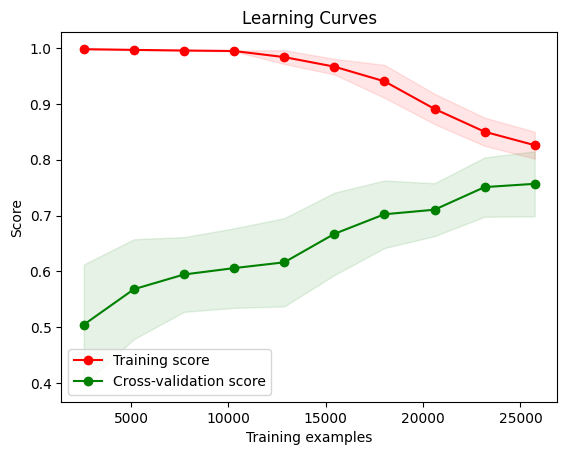

In [ ]:
from sklearn.model_selection import learning_curve

def plot_learning_curves(model, X_train, y_train, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=cv, n_jobs=-1, 
        train_sizes=np.linspace(.1, 1.0, 10),
        scoring='accuracy'
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title("Learning Curves")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")

    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


model = LogisticRegression(max_iter=1000)
plot_learning_curves(model, x_train, y_train, cv=5)
plt.show()
